In [2]:
import pandas as pd
from IPython.display import SVG, display, display_svg
import numpy as np
import cv2
import sys
import os
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath("../"))

In [3]:
from mrcad.render_utils import RenderConfig
from mrcad.action import Drawing
from tests.test_replay_agents import get_design_from_record, get_strokes_from_record

In [4]:
def executeActions(actions):
    '''
    Executes a list of ACTIONS and returns the geometries (points and curves) that are created/ modified by those actions.
    
    Note: there are slight discrepencies between this and the JS executing function.
    '''
    
    pt_id_ctr = 1
    points = {}
    curves = []
    cur_geometries = set()

    def add_geometry(geometry):
        geometry_str = str(geometry)
        
        if geometry_str in cur_geometries:
            return False
        
        else:
            cur_geometries.add(geometry_str)
            if geometry['name'] == 'pt':
                nonlocal pt_id_ctr
                pt_id = 'pt_' + str(pt_id_ctr)
                points[pt_id] = geometry
                pt_id_ctr += 1
            else:
                curves.append(geometry)
            return True
        
    def update_geometry_rep(geometry_old, geometry_new):
        
        geometry_str_old = str(geometry_old)
        
        if geometry_str_old in cur_geometries:
            cur_geometries.remove(geometry_str_old)
            cur_geometries.add(str(geometry_new))

    def get_line_repr_from_action(line_content):
        pt1_coord_i, pt1_coord_j = line_content[1]
        pt2_coord_i, pt2_coord_j = line_content[2]
        
        pt1_id = next((pt_id for pt_id, pt_obj in points.items() if pt_obj["i"] == pt1_coord_i and pt_obj["j"] == pt1_coord_j), None)
        pt2_id = next((pt_id for pt_id, pt_obj in points.items() if pt_obj["i"] == pt2_coord_i and pt_obj["j"] == pt2_coord_j), None)
        
        if pt1_id and pt2_id:
            return {"name": "line", "pt1": pt1_id, "pt2": pt2_id}
        return None

    def get_arc_repr_from_action(arc_content):
        curve_name = arc_content[0]
        pt1_coord_i, pt1_coord_j = arc_content[1]
        pt2_coord_i, pt2_coord_j = arc_content[2]
        pt3_coord_i, pt3_coord_j = arc_content[3]
        
        pt1_id = next((pt_id for pt_id, pt_obj in points.items() if pt_obj["i"] == pt1_coord_i and pt_obj["j"] == pt1_coord_j), None)
        pt2_id = next((pt_id for pt_id, pt_obj in points.items() if pt_obj["i"] == pt2_coord_i and pt_obj["j"] == pt2_coord_j), None)
        pt3_id = next((pt_id for pt_id, pt_obj in points.items() if pt_obj["i"] == pt3_coord_i and pt_obj["j"] == pt3_coord_j), None)
        
        if pt1_id and pt2_id and pt3_id:
            if curve_name == 'arc_3pt':
                if ((pt1_id != pt2_id) and (pt2_id != pt3_id)): # only add curve if distinct consecutive points
                    return {"name": "arc_3pt", "start": pt1_id, "mid": pt2_id, "end": pt3_id}
        return None

    def do_mk_curve_action(action):
        curve_content = action[1]
        curve_kind = curve_content[0]
        
        curve_repr = None
        if curve_kind == 'line':
            curve_repr = get_line_repr_from_action(curve_content)
        elif curve_kind == 'arc_3pt' or curve_kind == 'arc_cen':
            curve_repr = get_arc_repr_from_action(curve_content)
        
        if curve_repr:
            return add_geometry(curve_repr)
        return False
    
    def do_mk_pt_action(action):
        coord_i = action[1]
        coord_j = action[2]
        point = {"name": "pt", "i": coord_i, "j": coord_j}
        return add_geometry(point)
    
    def remove_geometry(geometry):
        
        geometry_str = str(geometry)
        if geometry_str not in cur_geometries:
            return False
        cur_geometries.remove(geometry_str)
        
        if geometry['name'] == 'pt':
            pt_id_to_remove = [pt_id for pt_id, val in points.items() if str(val) == geometry_str]
            for pt_id in pt_id_to_remove:
                del points[pt_id]
                # propagate deletion to geometries involving that point
                # Identify curves that use the deleted point
                curve_indices_to_remove = [c_id for c_id, curve in enumerate(curves) 
                                           if any(val == pt_id for val in curve.values())]

                for index in sorted(curve_indices_to_remove, reverse=True):
                    del curves[index]
        else:
            curves[:] = [curve for curve in curves if str(curve) != geometry_str]
        return True
    

    def fuse_points(pt_id_to_delete, pt_id_to_join):
        # moving pt_id_to_move on top of pt_id_to_join
        # will delete pt_id_to_move and preserve pt_id_to_join

        # Assume 'curves' is a list of dictionaries representing curves
        # and 'points' is a dictionary of points
        curves_to_delete = []

        # update point id in all curves
        for c_id in range(0, len(curves)):
            the_old_curve = curves[c_id].copy()
            the_curve = curves[c_id]
            changed = False
            # iterate over ids of all points and swap if it's being fused
#             for key in list(the_curve.keys()): # changed mon 13 nov
                
            for key in list(the_old_curve.keys()):
                if the_curve[key] == pt_id_to_delete:

                    the_curve[key] = pt_id_to_join
                    changed = True
                    
            if changed:
                update_geometry_rep(the_old_curve, the_curve)
                
                # if the curve is now invalid, delete
                if the_curve["name"] == "arc_3pt":
                    if (the_curve["start"] == the_curve["mid"]) or (the_curve["mid"] == the_curve["end"]):
                        # delete curve
                        curves_to_delete.append(c_id)
#                         remove_geometry(the_curve)
                elif the_curve["name"] == "line":
                    if (the_curve["pt1"] == the_curve["pt2"]):
                        # delete curve
#                         remove_geometry(the_curve)
                        curves_to_delete.append(curves[c_id])
        
        for curve in curves_to_delete:
            remove_geometry(curve)

        # Delete the point that's being moved
        remove_geometry({"name": "pt", "i" : points[pt_id_to_delete]["i"], "j": points[pt_id_to_delete]["j"]})
#         if pt_id_to_delete in points:
#             del points[pt_id_to_delete]


    for action in actions:
        
        if action == []:
            continue
        
        if action[0] == 'mk_pt':
            do_mk_pt_action(action)
            
        elif action[0] == 'del_pt':
            coord_i = action[1]
            coord_j = action[2]
            geometry = {"name": "pt", "i": coord_i, "j": coord_j}
            remove_geometry(geometry)
            
        elif action[0] == 'mv_pt':

            coord_i1 = action[1]
            coord_j1 = action[2]
            coord_i2 = action[3]
            coord_j2 = action[4]
            
            # see if point at exists at origin
#             for pt_id_to_move, pt_move_content in points.copy().items():
            for pt_id_to_move in list(points.keys()):
                pt_move_content = points[pt_id_to_move]
                if pt_move_content["i"] == coord_i1 and pt_move_content["j"] == coord_j1:
                    
                    # see if point at exists at destination
                    pt_id_to_join = None
                    for pt_id, pt_join_content in points.items():
                        if pt_join_content["i"] == coord_i2 and pt_join_content["j"] == coord_j2:
#                             assert pt_id_to_join == None
                            pt_id_to_join = pt_id

                    # if it does, fuse the points
                    if pt_id_to_join != None:
                        fuse_points(pt_id_to_move, pt_id_to_join)
                    # otherwise,
                    else:
                        geometry_old = {"name": "pt", "i" : points[pt_id_to_move]["i"], "j": points[pt_id_to_move]["j"]}
                        geometry_new = {"name": "pt", "i": coord_i2, "j": coord_j2}
                        points[pt_id_to_move]["i"] = coord_i2
                        points[pt_id_to_move]["j"] = coord_j2
                        update_geometry_rep(geometry_old, geometry_new)
                        break
                    
                    
        elif action[0] == 'mk_curve':
            do_mk_curve_action(action)
        elif action[0] == 'rm_curve':
            curve_content = action[1]
            curve_kind = curve_content[0]
            if curve_kind == 'line':
                remove_geometry(get_line_repr_from_action(curve_content))
            elif curve_kind == 'arc_3pt':
                remove_geometry(get_arc_repr_from_action(curve_content))
                
#         print(action, points, curves)

    return {
        "points": points,
        "curves": curves,
    }

In [5]:
def display_stroke(path_data):
    svg_str = f"""
    <svg height="400" width="400" xmlns="http://www.w3.org/2000/svg">
        <path d="{path_data}" stroke="black" fill="transparent"/>
    </svg>
    """
    display(SVG(data=svg_str))
    
    
def display_strokes(path_data_list, increment_colors = False):
    
    distinct_colors = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
        '#f0f8ff', '#faebd7', '#00ffff', '#7fffd4', '#f0ffff', 
        '#f5f5dc'
    ]

    
    if increment_colors:
        path_elements = '\n'.join(f'<path d="{d}" stroke="{distinct_colors[i % len(distinct_colors) ]}" stroke_weight="2px" fill="transparent"/>' for i, d in enumerate(path_data_list))
    
    else:
        path_elements = '\n'.join(f'<path d="{d}" stroke="red" stroke_weight="2px" fill="transparent"/>' for d in path_data_list)
    
    svg_str = f"""
    <svg height="400" width="400" xmlns="http://www.w3.org/2000/svg">
        {path_elements}
    </svg>
    """
    display(SVG(data=svg_str))

In [6]:
instructions_df = pd.read_csv("../tests/df_instructions_mcad-async-internal-pilot-go.csv")

In [7]:
instructions_df.columns

Index(['Unnamed: 0', '_id', 'iterationName', 'clientId', 'dyadId',
       'trialStartTime', 'turnStartTime', 'relativeTimeTrial',
       'relativeTimeTurn', 'absoluteTime', 'condition', 'targetId', 'trialNum',
       'turnNum', 'roundNum', 'role', 'context', 'turnSwitchTime',
       'thinkingTime', 'nReset', 'prevActions', 'prevJsGeometries',
       'speakerTimeLimit', 'listenerTimeLimit', 'text', 'strokes', 'target',
       'generation', 'strokeSVGs', 'timeSent', 'sendReason',
       'latestTypingEventAbsolute', 'latestTypingEventRelativeTrial',
       'latestTypingEventRelativeTurn', 'user', 'sketch', 'timeReceived',
       'eventType'],
      dtype='object')

In [8]:
instructions_df.targetId.unique()

array(['sg_all_393866', 'sg_all_7693270', 'sg_all_1589837',
       'sg_all_579833', 'sg_all_63964', 'sg_all_4780767',
       'sg_all_3668922', 'sg_all_205729', 'sg_all_4772936',
       'sg_all_4041550', 'sg_all_626164', 'sg_all_2919900',
       'sg_all_596938', 'sg_all_1558145', 'sg_all_1745954',
       'sg_all_197770', 'sg_all_1490425', 'sg_all_24719', 'sg_all_22993',
       'sg_all_12517918', 'sg_all_3802651', 'sg_all_190606',
       'sg_all_8922183', 'sg_all_12864860', 'sg_all_6508064',
       'sg_all_10635276'], dtype=object)

In [9]:
target_id = "sg_all_7693270"

In [10]:
target = get_design_from_record(
    eval(instructions_df[instructions_df.targetId == target_id].target.iloc[0])[
        "uncompressed_geometries"
    ]
)
instructions = instructions_df[
    instructions_df.targetId == target_id
].sort_values(by="generation", ascending=True)[
    ["context", "generation", "text", "strokes"]
]

In [18]:
current_design = get_design_from_record(executeActions(eval(instructions.context.iloc[2])['prevActions']))
img = current_design.to_image(ignore_out_of_bounds=True)
drawing = Drawing(get_strokes_from_record(eval(instructions.strokes.iloc[2])))
img = drawing.to_image(img)

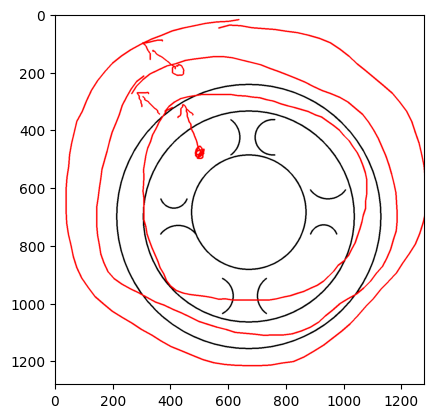

In [19]:
plt.imshow(img)